In [1]:
import time
ti = time.time()

import numpy as np
import xarray as xr
import scipy.linalg as spl
from scipy.io import loadmat

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)
from perlmutterNotebooks.calc_GW_LRF import g ,Lv,cp,Rd,T0,coupled_gw_mode,gw_mode_forced
from perlmutterNotebooks.coupling_matrices import lhsmatrix_rhsvec,rhsmatrix

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
##############################################################
######################### GW PARAMETERS ######################
##############################################################
U0=10
kSAM = 1e-4
hhatSAM = 50.
prefix = "MOUNTAINWAVE_128x128x64_mtnwave_k1e-4_h50_U10"


jobno = "12345"
ncfilename = "/pscratch/sd/q/qnicolas/GWdata/GW_%s.nc"%jobno

mode = 'init'

if mode=='init':
    print("Initializing Gravity wave ...")
elif mode=='update':
    print("Updating Gravity wave ...")
    iteration_no = 1
else:
    raise ValueError("Second argument is either 'init' or 'update'")
    
print("Parameters: U0 = %.1f, k = %.3e, hhat = %.3f"%(U0,kSAM,hhatSAM))

###############################################################
###### LOAD Z. KUANG LRF AND REVERSE POSITIVE EIGENVALUE ######
###############################################################
kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")
Mkuang=kuangdata['M']
zrce = kuangdata['z'][:,0]
#Reverse positive eigenvalue
lambdas,P = spl.eig(Mkuang)
lambdas[5]*=-1
Pm1 = spl.inv(P)
Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

################################################################
### LOAD SAM GRID INFO AND STABILITY/MOISTURE STRATIFICATION ###
################################################################
stat = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_STAT/RCE_128x128x64_ref_rce.nc")

samgrid = stat.z.data
zz_full = np.concatenate(([0.],samgrid,[27300,27500])) # increase top resolution for BC
n = len(zz_full)

Nsam = np.sqrt(g/T0*stat.DSE[-240:].mean('time').differentiate('z'))
Nsam[0] = Nsam[1]
Nsam[-2:] = Nsam[-3]
Nsam_full = np.concatenate(([Nsam[0]],Nsam,[Nsam[-1],Nsam[-1]]))

dqdzsam = stat.QV[-240:].mean('time').differentiate('z')/1e3
dqdzsam_full = np.concatenate(([dqdzsam[0]],dqdzsam,[dqdzsam[-1],dqdzsam[-1]]))

Initializing Gravity wave ...
Parameters: U0 = 10.0, k = 1.000e-04, hhat = 50.000


/global/common/software/m3310/xrdask.2023.04.qn/lib/python3.9/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [3]:
##############################################################
######################### CALCULATE GW #######################
##############################################################
#w0 = gw_mode_forced(zz_full,Nsam_full**2/U0**2,kSAM,hhatSAM,U0,0*zz_full)
w1,T1,q1,Qc1,Qq1 = coupled_gw_mode(zz_full,zrce,Nsam_full**2*T0/g,dqdzsam_full,kSAM,hhatSAM,U0,Mkuang2,coupling='full',itp_matrices=None)

##############################################################
################# STORE GW INFO IN NETCDF FILE ###############
##############################################################

gw_xr = xr.Dataset(data_vars=dict(
                       w_re=(["iteration","z"], np.real(w1).reshape((1,n)), {"units":"m/s"}),
                       w_im=(["iteration","z"], np.imag(w1.reshape((1,n))), {"units":"m/s"}),
                       Tprime_re=(["iteration","z"], np.real(T1).reshape((1,n)), {"units":"K"}),
                       Tprime_im=(["iteration","z"], np.imag(T1).reshape((1,n)), {"units":"K"}),
                       qprime_re=(["iteration","z"], np.real(q1).reshape((1,n)), {"units":"g/kg"}),
                       qprime_im=(["iteration","z"], np.imag(q1).reshape((1,n)), {"units":"g/kg"}),
                       Qc_re=(["iteration","z"], np.real(Qc1).reshape((1,n)), {"units":"K/s"}),
                       Qc_im=(["iteration","z"], np.imag(Qc1).reshape((1,n)), {"units":"K/s"}),
                       Qq_re=(["iteration","z"], np.real(Qq1).reshape((1,n)), {"units":"g/kg/s"}),
                       Qq_im=(["iteration","z"], np.imag(Qq1).reshape((1,n)), {"units":"g/kg/s"}),
                   ),
                   coords=dict(
                       iteration=(["iteration"], [0]),
                       z=(["z"], zz_full)
                   ),
                   attrs=dict(description="GW info, job n°%s"%jobno),
               )
#print(gw_xr)
#gw_xr.to_netcdf(ncfilename,mode='w')
#    
    
    
  

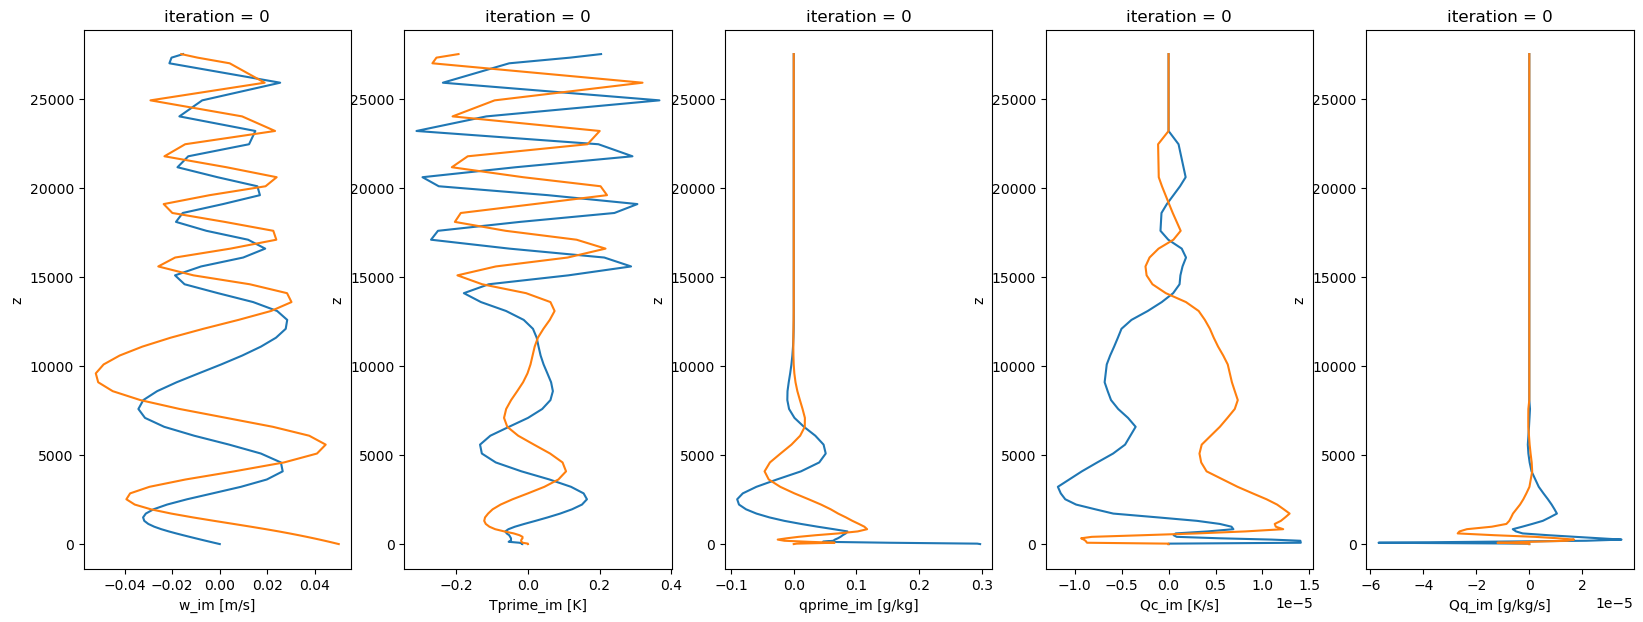

In [4]:
_,axs = plt.subplots(1,5,figsize=(20,7))
gw_xr.w_re[-1].plot(ax=axs[0],y='z')
gw_xr.w_im[-1].plot(ax=axs[0],y='z')
gw_xr.Tprime_re[-1].plot(ax=axs[1],y='z')
gw_xr.Tprime_im[-1].plot(ax=axs[1],y='z')
gw_xr.qprime_re[-1].plot(ax=axs[2],y='z')
gw_xr.qprime_im[-1].plot(ax=axs[2],y='z')
gw_xr.Qc_re[-1].plot(ax=axs[3],y='z')
gw_xr.Qc_im[-1].plot(ax=axs[3],y='z')
gw_xr.Qq_re[-1].plot(ax=axs[4],y='z')
gw_xr.Qq_im[-1].plot(ax=axs[4],y='z')

In [5]:
  
#gw_xr = xr.open_dataset(ncfilename)
##############################################################
######################### CALCULATE GW #######################
##############################################################
# First, read T,q data from the previous iteration
#prev_iter_re = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_STAT/"+prefix+"_real.nc")
#prev_iter_im = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMimdata/OUT_STAT/"+prefix+"_imag.nc")

#Tprime_i_re = prev_iter_re.TABS[-24:].mean('time')-stat.TABS[-240:].mean('time')
#qprime_i_re = prev_iter_re.QV[-24:].mean('time')-stat.QV[-240:].mean('time')
#Tprime_i_im = prev_iter_im.TABS[-24:].mean('time')-stat.TABS[-240:].mean('time')
#qprime_i_im = prev_iter_im.QV[-24:].mean('time')-stat.QV[-240:].mean('time')

Tprime_i_re = gw_xr.Tprime_re.isel(iteration=-1).data
qprime_i_re = gw_xr.qprime_re.isel(iteration=-1).data
Tprime_i_im = gw_xr.Tprime_im.isel(iteration=-1).data
qprime_i_im = gw_xr.qprime_im.isel(iteration=-1).data

In [10]:
zeroout_matrix = np.eye(n)
zeroout_matrix[45:,45:] = 0.

zeroTq_i = np.concatenate([np.zeros(n),np.dot(zeroout_matrix,Tprime_i_re+1j*Tprime_i_im),np.dot(zeroout_matrix,qprime_i_re+1j*qprime_i_im)])

AA,bb = lhsmatrix_rhsvec(zz_full,Nsam_full**2*T0/g,dqdzsam_full,kSAM,hhatSAM,U0)
BB = rhsmatrix(zz_full,zrce,kSAM,U0,Mkuang2)    

wQ_i = np.concatenate([(gw_xr.w_re+1j*gw_xr.w_im).isel(iteration=-1),
                       (gw_xr.Qc_re+1j*gw_xr.Qc_im).isel(iteration=-1),
                       (gw_xr.Qq_re+1j*gw_xr.Qq_im).isel(iteration=-1)])
wQ_ip1 = spl.solve(AA-BB, -1j*kSAM*U0*zeroTq_i -np.dot(BB,wQ_i) + bb)

w1 = wQ_ip1[:n]
Qc1 = wQ_ip1[n:2*n]
Qq1 = wQ_ip1[2*n:3*n]

In [11]:
##############################################################
################# STORE GW INFO IN NETCDF FILE ###############
##############################################################

gw_xr2 = xr.Dataset(data_vars=dict(
                       w_re=(["iteration","z"], np.real(w1).reshape((1,n)), {"units":"m/s"}),
                       w_im=(["iteration","z"], np.imag(w1.reshape((1,n))), {"units":"m/s"}),
                       Tprime_re=(["iteration","z"], Tprime_i_re.reshape((1,n)), {"units":"K"}),
                       Tprime_im=(["iteration","z"], Tprime_i_im.reshape((1,n)), {"units":"K"}),
                       qprime_re=(["iteration","z"], qprime_i_re.reshape((1,n)), {"units":"g/kg"}),
                       qprime_im=(["iteration","z"], qprime_i_im.reshape((1,n)), {"units":"g/kg"}),
                       Qc_re=(["iteration","z"], np.real(Qc1).reshape((1,n)), {"units":"K/s"}),
                       Qc_im=(["iteration","z"], np.imag(Qc1).reshape((1,n)), {"units":"K/s"}),
                       Qq_re=(["iteration","z"], np.real(Qq1).reshape((1,n)), {"units":"g/kg/s"}),
                       Qq_im=(["iteration","z"], np.imag(Qq1).reshape((1,n)), {"units":"g/kg/s"}),
                   ),
                   coords=dict(
                       iteration=(["iteration"], [1]),
                       z=(["z"], zz_full)
                   ),
                   attrs=dict(description="GW info, job n°%s"%jobno),
               )

#gw_xr_new = xr.concat((gw_xr,gw_xr2),dim="iteration")
#gw_xr.close()
#gw_xr_new.to_netcdf(ncfilename)

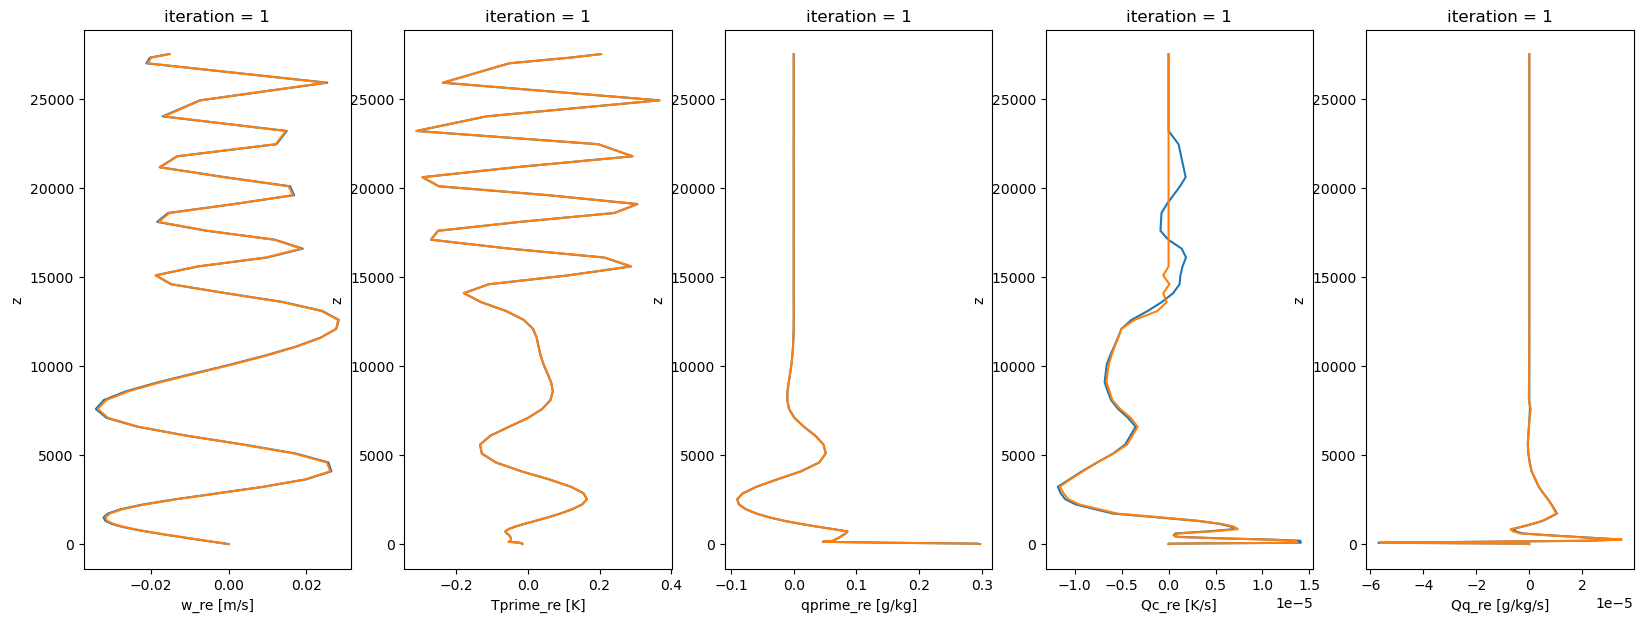

In [12]:
_,axs = plt.subplots(1,5,figsize=(20,7))
gw_xr.w_re[-1].plot(ax=axs[0],y='z')
gw_xr2.w_re[-1].plot(ax=axs[0],y='z')
gw_xr.Tprime_re[-1].plot(ax=axs[1],y='z')
gw_xr2.Tprime_re[-1].plot(ax=axs[1],y='z')
gw_xr.qprime_re[-1].plot(ax=axs[2],y='z')
gw_xr2.qprime_re[-1].plot(ax=axs[2],y='z')
gw_xr.Qc_re[-1].plot(ax=axs[3],y='z')
gw_xr2.Qc_re[-1].plot(ax=axs[3],y='z')
gw_xr.Qq_re[-1].plot(ax=axs[4],y='z')
gw_xr2.Qq_re[-1].plot(ax=axs[4],y='z')

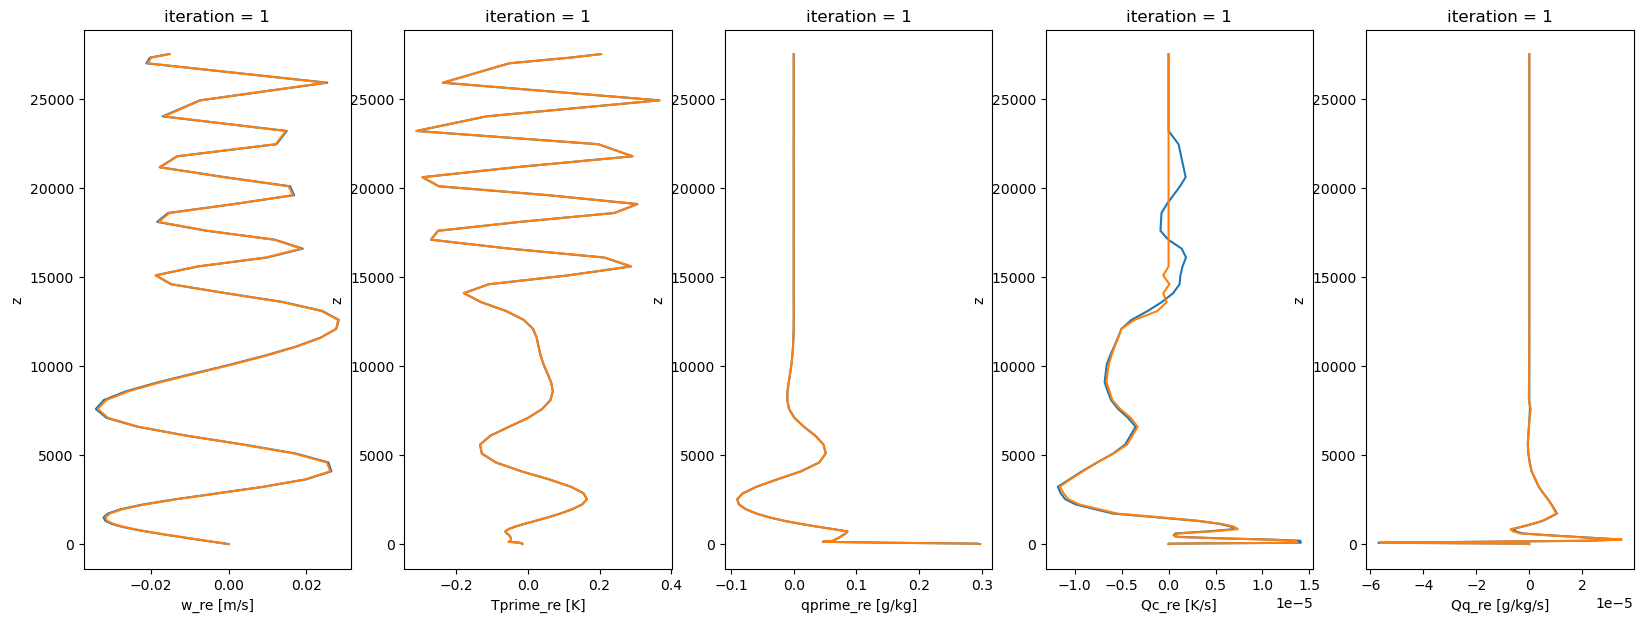

In [13]:
_,axs = plt.subplots(1,5,figsize=(20,7))
gw_xr.w_re[-1].plot(ax=axs[0],y='z')
gw_xr2.w_re[-1].plot(ax=axs[0],y='z')
gw_xr.Tprime_re[-1].plot(ax=axs[1],y='z')
gw_xr2.Tprime_re[-1].plot(ax=axs[1],y='z')
gw_xr.qprime_re[-1].plot(ax=axs[2],y='z')
gw_xr2.qprime_re[-1].plot(ax=axs[2],y='z')
gw_xr.Qc_re[-1].plot(ax=axs[3],y='z')
gw_xr2.Qc_re[-1].plot(ax=axs[3],y='z')
gw_xr.Qq_re[-1].plot(ax=axs[4],y='z')
gw_xr2.Qq_re[-1].plot(ax=axs[4],y='z')

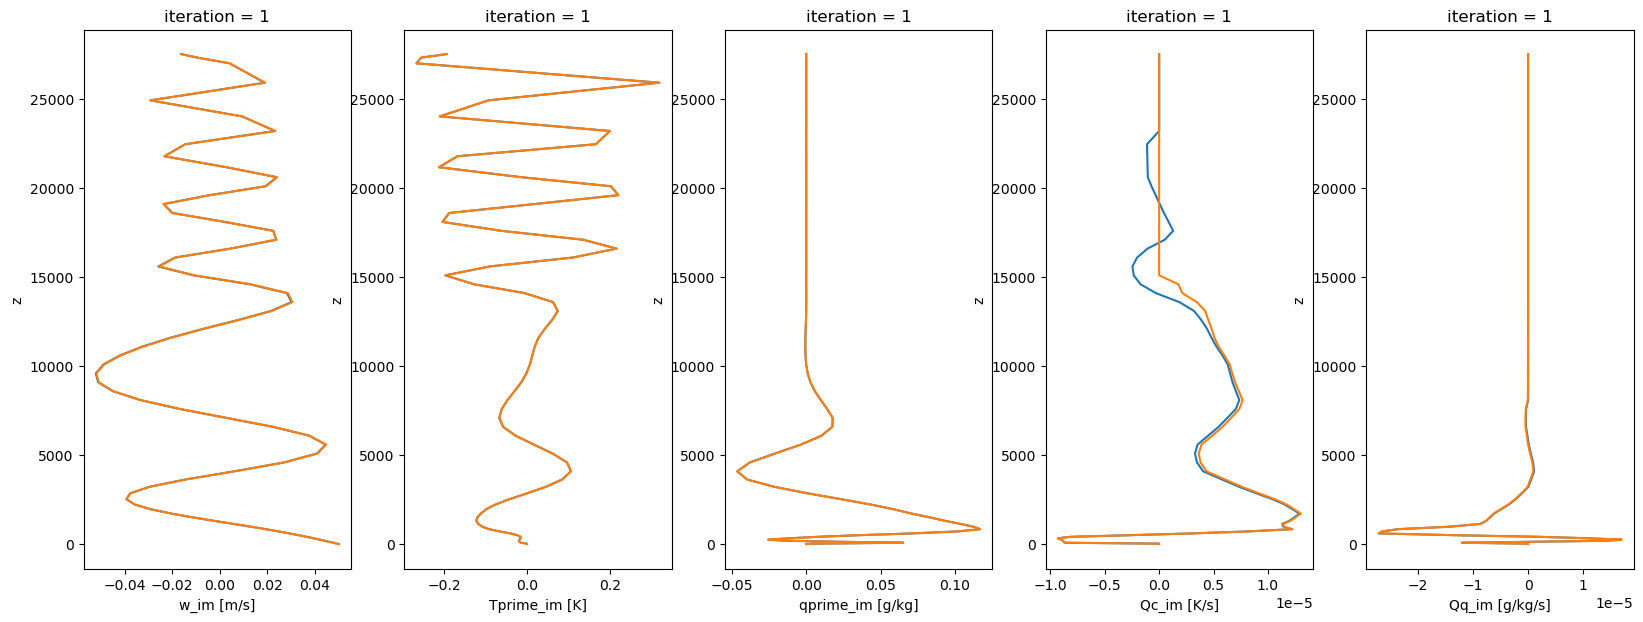

In [9]:
_,axs = plt.subplots(1,5,figsize=(20,7))
gw_xr.w_im[-1].plot(ax=axs[0],y='z')
gw_xr2.w_im[-1].plot(ax=axs[0],y='z')
gw_xr.Tprime_im[-1].plot(ax=axs[1],y='z')
gw_xr2.Tprime_im[-1].plot(ax=axs[1],y='z')
gw_xr.qprime_im[-1].plot(ax=axs[2],y='z')
gw_xr2.qprime_im[-1].plot(ax=axs[2],y='z')
gw_xr.Qc_im[-1].plot(ax=axs[3],y='z')
gw_xr2.Qc_im[-1].plot(ax=axs[3],y='z')
gw_xr.Qq_im[-1].plot(ax=axs[4],y='z')
gw_xr2.Qq_im[-1].plot(ax=axs[4],y='z')